---

<center><h1 style="font-size:40px;">Exercise IV<br>Image Segmentation using CNNs</h1></center>

---

In this exercise, we will design a CNN-based **encoder-decoder architecture** to segment rgb images. Image segmentation refers to dividing the image into semantically meaningful regions. For instance, representing each object in the scene with a unique color. 

All **tasks** include **TODO's** thare are expected to be done before the deadline. The highlighted **Question's** should be answered in the report. Keep the answers separated so it is easy to read for the grading. Some sections include asserts or an expected result to give a and expected results are given. Some sections does not contain any **TODO's** but is good to understand them. 

For the **report** we have prepared an *Report.ipynb* notebook. The report should act as a summary of your findings and motivate your choice of approach. A better motivation show your understanding of the lab. Dont forget to include all **parts** in the report!


Good luck!

---

# Import packages

In [1]:
%load_ext autoreload
%autoreload 2
# Hacky solution to ac>cess the global utils package
import sys,os
sys.path.append(os.path.dirname(os.path.realpath('')))

In [21]:
# Torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

# local modules
from torch.utils.data import DataLoader
from utils.dataset import SegmentationDataset
from utils.model import Model
from utils.progressbar import LitProgressBar
from config import LabConfig
import torchvision
from utils import plot
import pytorch_lightning as pl
from pytorch_lightning.callbacks.progress import RichProgressBar
from rich.progress import track

import torchgeometry as tgm
from torchgeometry.losses import DiceLoss
import torchmetrics
import transforms as T

## Load config
Note that this lab does not support for fineGrained dataset.

In [3]:
cfg = LabConfig()
cfg.todict()

{'CLASSES': ['square', 'triangle', 'circular', 'background'],
 'fineGrained': False,
 'NUM_CLASSES': 4,
 'training_img_dir': '../data/FlyingObjectDataset_10K/training',
 'validation_img_dir': '../data/FlyingObjectDataset_10K/validation',
 'testing_img_dir': '../data/FlyingObjectDataset_10K/testing',
 'SEED': 420,
 'GPU': 0,
 'IMAGE_WIDTH': 128,
 'IMAGE_HEIGHT': 128,
 'IMAGE_CHANNEL': 3,
 'NUM_WORKERS': 4,
 'BATCH_SIZE': 32,
 'TENSORBORD_DIR': 'logs/'}

# Example Task
Here is an example of how the network can be setup to train a network to learn semantic segmentation of images.

## Example data
First load the dataloaders for three datasets; train, validation and test. Feel free to test different augmentations, more can be found at the [pytorch doc](https://pytorch.org/vision/stable/transforms.html)

Note that ToTensor and Rezise are required to reshape and transform the images correct. We do not want to apply augmentation to the test_transform that are applied on the validation and test dataloader. For semantic segmentation we do not only have an input image $x$ but also an target label $y$. If we apply example: *RandomHorizontalFlip* the expected target image will be observed but will not be same rotation.

### Augmentation
Augmentation is a good approach to increase the number of samples for a dataset. However, poor augmentations include transforms that modify the input image to a new image that cant be found in the original dataset. An example would be to change the perspective of the image which would not exist in the original dataset.

In [4]:
train_transform = T.Compose([
    T.ToTensor(),
    T.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)), 
    T.RandomHorizontalFlip(0.7),
])
test_transform = T.Compose([
    T.ToTensor(),
    T.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),
])

### Create dataloaders

In [5]:
train_dataloader = DataLoader(SegmentationDataset(cfg.training_img_dir, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), transforms=train_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=True,
                        num_workers=cfg.NUM_WORKERS)
valid_dataloader = DataLoader(SegmentationDataset(cfg.validation_img_dir, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), transforms=test_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=False,
                        num_workers=cfg.NUM_WORKERS)
test_dataloader = DataLoader(SegmentationDataset(cfg.testing_img_dir, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), transforms=test_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=False,
                        num_workers=cfg.NUM_WORKERS)

predict_dataloader = DataLoader(SegmentationDataset(cfg.testing_img_dir, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), predict=True, transform=test_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=False,
                        num_workers=cfg.NUM_WORKERS)
print("Data batch generators are created!")

Data batch generators are created!


## Visualise data
To get an idea of the dataset we will first plot the data. This is very important, especially if we perform data augmentation. If the implementation is wrong an qualitative estimation will with a great probability tell if something is wrong.

**OPTIONAL:** Add RandomFlip to *train_transform*. What happens to the images below? Observe that we take the transformations from *transforms.py* to perform same transformations on both image and target.

x (32, 4, 128, 128) torch.float32 0.0 1.0
y (32, 128, 128) torch.int64 0 3


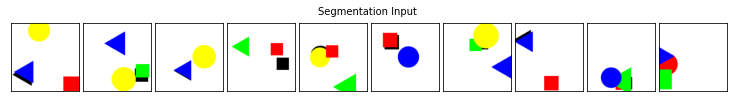

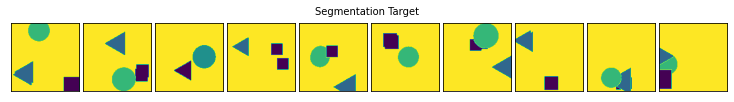

In [6]:
t_x, t_y = next(iter(train_dataloader))
print(f"x {tuple(t_x.shape)} {t_x.dtype} {t_x.min()} {t_x.max()}")
print(f"y {tuple(t_y.shape)} {t_y.dtype} {t_y.min()} {t_y.max()}")
plot.Segmentation.data(t_x[:,:3], t_y, nrows=1)

In [7]:
from torchvision import transforms

In [8]:
transforms

<module 'torchvision.transforms' from '/home/stud/e/erilid17/.conda/envs/deeplearn/lib/python3.9/site-packages/torchvision/transforms/__init__.py'>

In [9]:
if True: # Change to true to see statistics
    plot.data_statistics(cfg.training_img_dir, fineGrained=cfg.fineGrained, title=" Training Data Statistics ")
    plot.data_statistics(cfg.validation_img_dir, fineGrained=cfg.fineGrained, title=" Validation Data Statistics ")
    plot.data_statistics(cfg.testing_img_dir, fineGrained=cfg.fineGrained, title=" Testing Data Statistics ")


 ######################################################################
#####################  Training Data Statistics  ##################### 
######################################################################
total image number 	 10817
total class number 	 3
class square 	 3488 images
class circular 	 3626 images
class triangle 	 3703 images
######################################################################

 ######################################################################
#####################  Validation Data Statistics  ##################### 
######################################################################
total image number 	 2241
total class number 	 3
class triangle 	 745 images
class square 	 783 images
class circular 	 713 images
######################################################################

 ######################################################################
#####################  Testing Data Statistics  ##################### 
##############

## Create model
During training process the training loss can stop decrease but also far from a desired value. This occured due to the vanishing gradient. This can be observed as for every layer that we go backwards in the network the network gradient gets smaller and smaller.

Skip connections in deep architectures, skip some layer in the neural network and feeds the output of one layer as the input to the next layers. This provide an alternative path for the gradient during backpropagation. Therefore, the skip connections help to preserve the gradient.

Skip connections is also very popular for semantic segmentation where information captured in the initial layers also would like to be learned in later layers.
It has been observed that in earlier layers the learned features correspond to lower semantic information that is extracted from the input.

Therefore, for this lab we will use skip connections for the auto encoder. More specifically, a U-Net. The skip connections are placed at each step of the encoder and feeding information to the decoder. The size of the input must be the same for both encoder and decoder where skip connections are applied. 

<center>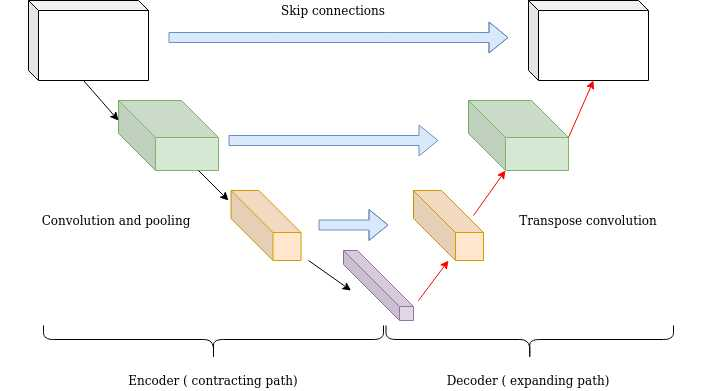</center>


In [132]:
class SimpleModel(nn.Module):
    def __init__(self, num_classes:int=3,input_shape=(10,10),**kwargs):
        super().__init__()
        
        ## Encoder
        self.conv1 = self.Encoder(num_classes, 32, 7, 3)
        self.conv2 = self.Encoder(32, 64, 3, 1)
        self.conv3 = self.Encoder(64, 128, 3, 1)
        
        # Decoder
        self.upconv3 = self.Decoder(128, 64, 3, 1)
        self.upconv2 = self.Decoder(64*2, 32, 3, 1)
        self.upconv1 = self.Decoder(32*2, num_classes, 3, 1)

    def forward(self, x):

        # Downsample
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        
        # Upsample
        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def Encoder(self, in_channels, out_channels, kernel_size, padding):

        return nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )


    def Decoder(self, in_channels, out_channels, kernel_size, padding):
        return nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
        )

In [11]:
# Train model
config = {
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":0.005,
        }
    },
    'criterion':torch.nn.CrossEntropyLoss(), # error function
    'max_epochs':5,
    "train_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.IoU(num_classes=cfg.NUM_CLASSES,compute_on_step=False)
    ],postfix="_Train"),
    "validation_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.IoU(num_classes=cfg.NUM_CLASSES,compute_on_step=False)
    ],postfix="_Validation"),
    "test_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.IoU(num_classes=cfg.NUM_CLASSES,compute_on_step=False)
    ],postfix="_test")
}

In [133]:
# Load model
modelObj = Model(SimpleModel(num_classes=cfg.NUM_CLASSES, input_shape=(cfg.IMAGE_CHANNEL, cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),**config)

# Setup trainer
trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=1,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
            callbacks=[RichProgressBar()],
            enable_model_summary=False, # Can be None, top or full
            num_sanity_val_steps=10,   
        )
# Train with the training and validation data- 
trainer.fit(
    modelObj, 
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader
);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

## Test the network on the test dataset
To test the performance for a qualitative estimation we can plot the input, target and the models prediction. This is a good approach to see the performance and understand if the model is close to a correct decision. However, for big data, we probobly want to focus on a qualitative estimation. Therefore we can analyse **Tensorboard** logs to get a better understanding of the model.

In [13]:
# Create iterable from the test dataset
iter_dataloader = iter(test_dataloader)

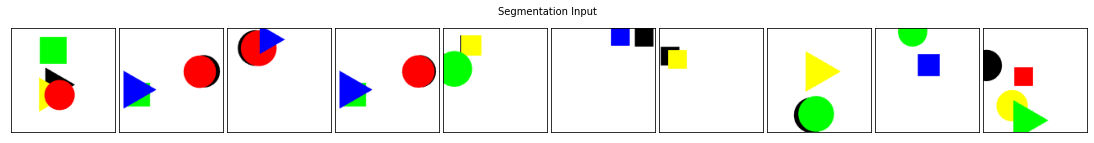

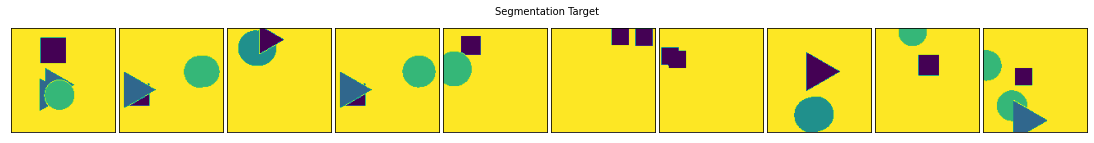

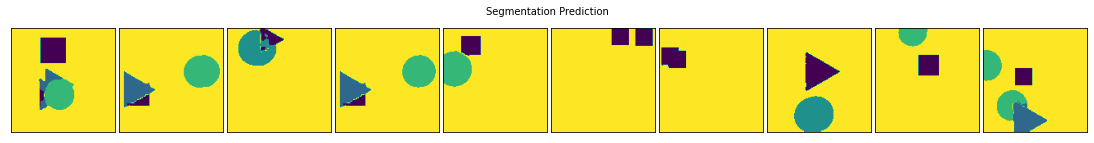

In [14]:
# Take one batch from the test dataset and predict!
t_data, t_segments = next(iter_dataloader)
pred_segments = torch.argmax(modelObj.predict_step(t_data,0,0),dim=1)

plot.Segmentation.results(t_data[:,:3], pred_segments,Y=t_segments, nrows=1, fig_dimension=1.5)

In [15]:
# # This did work for logging multiple metrics on whole testloader but suddenly stopped working and now hangs in the last iterations
# trainer.test(modelObj, dataloaders=test_dataloader)

# Exercises

## Metrics
**TODO:** Does a high accuracy imply a good model, motivate your answer.

In this case we have a case of uneven data. The background takes up the most of the space so this is a case for accuracy vs precision vs specificity. 

**TODO:** Find an alternative metric that could represent better the task at hand (think about what we are trying to do with semantic segmentation)

Given the task at hand we are trying to segment pictures we can use look at the intersection between ground truth and predictions. This metric is called Intersection of Union and it is the ratio between the overlap of ground truth and prediction and the union of ground truth and prediction.

## Loss

**TODO:** Is there any other loss more suitable for the task? ## Metrics


In [19]:
# Accuracy
def get_accuracy(model, iter_dataloader):
    metric = torchmetrics.Accuracy()
    for X, Y in track(iter_dataloader):
        preds = torch.argmax(model.predict_step(X,0,0),dim=1)
        acc = metric(preds, Y)
    return metric.compute()

# IoU
def get_IoU(model, iter_dataloader):
    metric = torchmetrics.IoU(num_classes=cfg.NUM_CLASSES)
    for X, Y in track(iter_dataloader):
        preds = torch.argmax(model.predict_step(X,0,0),dim=1)
        iou = metric(preds, Y)
    return metric.compute()

In [134]:
print('Acc: {:.4f}'.format(get_accuracy(modelObj, iter(test_dataloader)).item()))

Output()

Acc: 0.9964


In [135]:
print('IoU: {:.4f}'.format(get_IoU(modelObj, iter(test_dataloader)).item()))

Output()

IoU: 0.9744


In [29]:
# Configuration
config = {
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":0.005,
        }
    },
    'criterion':DiceLoss(), # error function
    'max_epochs':20,
    "train_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.IoU(num_classes=cfg.NUM_CLASSES,compute_on_step=False)
    ],postfix="_Train"),
    "validation_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.IoU(num_classes=cfg.NUM_CLASSES,compute_on_step=False)
    ],postfix="_Validation"),
    "test_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.IoU(num_classes=cfg.NUM_CLASSES,compute_on_step=False)
    ],postfix="_test")
}

## Architecture
Modify the architecture of the SimpleModel to further increase the performance. Remember that very deep network allow the network to learn many features but if the dataset is to small the model will underfit. A simple dataset should not require a very deep network to learn good features.

**TODO:** Modify the SimpleModel architecture. Force the network to overfit. How bad performance can you get from the network?

**TODO:** Modify the SimpleModel and increase the complexity a little. Does the performance improve? If not, did you modify it to much or to little?

**TODO:** Modify the SimpleModel architecture. Now combine the hyperparameter tuning and modification of the architecture to reach a performance that is close to the truth images. Explain in detail why the change was applied and if it improved the model a lot.

In [62]:
config['max_epochs'] = 20
config['optimizer']['args']['lr'] = 0.005
config['criterion'] = DiceLoss()

In [73]:
class OverfitModel(nn.Module):
    def __init__(self, num_classes:int=3,input_shape=(10,10),**kwargs):
        super().__init__()
        
        ## Encoder
        self.conv1 = self.Encoder(num_classes, 32, 7, 3)
        self.conv2 = self.Encoder(32, 64, 3, 1)
        self.conv3 = self.Encoder(64, 128, 3, 1)
        
        # Decoder
        self.upconv3 = self.Decoder(128, 64, 3, 1)
        self.upconv2 = self.Decoder(64*1, 32, 3, 1)
        self.upconv1 = self.Decoder(32*3, num_classes, 3, 1)

    def forward(self, x):

        # Downsample
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        #conv3 = self.conv3(conv2)
        
        # Upsample
        #upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(conv2, 1)
        upconv1 = self.upconv1(torch.cat([upconv2, conv1, conv1], 1))

        return upconv1

    def Encoder(self, in_channels, out_channels, kernel_size, padding):

        return nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )


    def Decoder(self, in_channels, out_channels, kernel_size, padding):
        return nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
        )

In [74]:
# Load model
modelObj = Model(OverfitModel(num_classes=cfg.NUM_CLASSES, input_shape=(cfg.IMAGE_CHANNEL, cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),**config)

# Setup trainer
trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=1,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
            callbacks=[RichProgressBar()],
            enable_model_summary=False, # Can be None, top or full
            num_sanity_val_steps=10,   
        )
# Train with the training and validation data- 
trainer.fit(
    modelObj, 
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader
);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

In [69]:
print('IoU: {:.4f}'.format(get_IoU(modelObj, iter(test_dataloader)).item()))

Output()

IoU: 0.9173


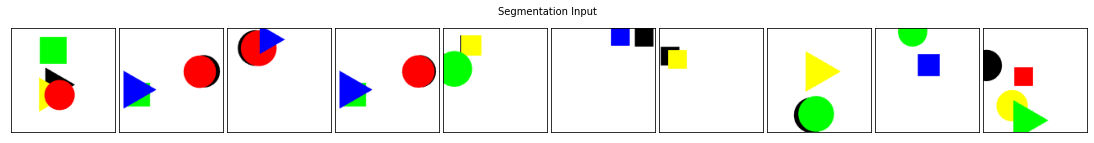

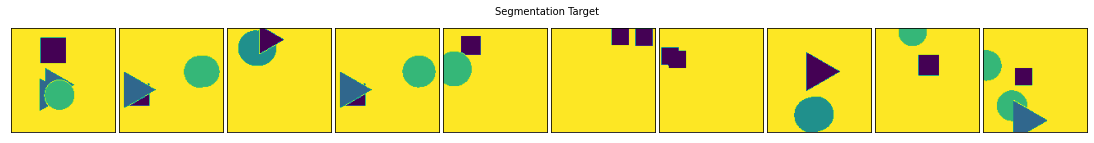

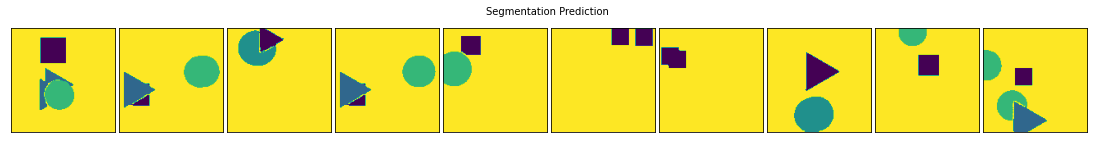

In [75]:
t_data, t_segments = next(iter(test_dataloader))
pred_segments = torch.argmax(modelObj.predict_step(t_data,0,0),dim=1)

plot.Segmentation.results(t_data[:,:3], pred_segments,Y=t_segments, nrows=1, fig_dimension=1.5)

### Improved Model

In [122]:
config['max_epochs'] = 10
config['optimizer']['args']['lr'] = 0.005

In [143]:
class ImprovedModel(nn.Module):
    def __init__(self, num_classes:int=3,input_shape=(10,10),**kwargs):
        super().__init__()
        
        ## Encoder
        self.conv1 = self.Encoder(num_classes, 32, 7, 3)
        self.conv2 = self.Encoder(32, 64, 3, 1)
        self.conv3 = self.Encoder(64, 128, 3, 1)
        self.conv4 = self.Encoder(128, 256, 3, 1)
        
        # Decoder
        self.upconv4 = self.Decoder(256, 128, 3, 1)
        self.upconv3 = self.Decoder(128*2, 64, 3, 1)
        self.upconv2 = self.Decoder(64*2, 32, 3, 1)
        self.upconv1 = self.Decoder(32*2, num_classes, 3, 1)

    def forward(self, x):

        # Downsample
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        
        # Upsample
        upconv4 = self.upconv4(conv4)
        upconv3 = self.upconv3(torch.cat([upconv4, conv3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def Encoder(self, in_channels, out_channels, kernel_size, padding):

        return nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )


    def Decoder(self, in_channels, out_channels, kernel_size, padding):
        return nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
        )

In [144]:
# Load model
modelObj = Model(ImprovedModel(num_classes=cfg.NUM_CLASSES, input_shape=(cfg.IMAGE_CHANNEL, cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),**config)

# Setup trainer
trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=1,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
            callbacks=[RichProgressBar()],
            enable_model_summary=False, # Can be None, top or full
            num_sanity_val_steps=10,   
        )
# Train with the training and validation data- 
trainer.fit(
    modelObj, 
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader
);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

In [145]:
print('IoU: {:.4f}'.format(get_IoU(modelObj, iter(test_dataloader)).item()))

Output()

IoU: 0.9808


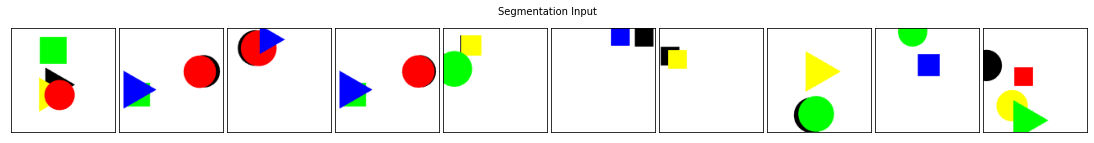

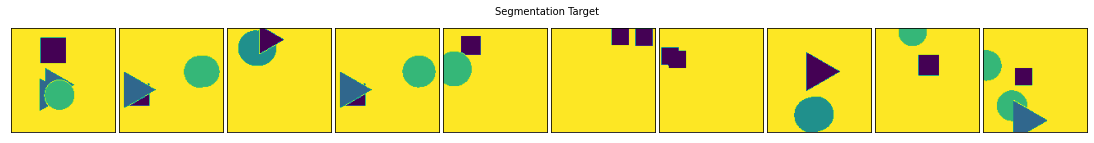

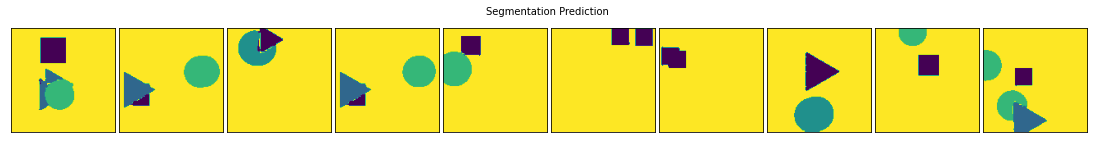

In [146]:
t_data, t_segments = next(iter(test_dataloader))
pred_segments = torch.argmax(modelObj.predict_step(t_data,0,0),dim=1)

plot.Segmentation.results(t_data[:,:3], pred_segments,Y=t_segments, nrows=1, fig_dimension=1.5)

## Hyperparameter tuning
### Task 1
From the example approach we can see that the network performed very poorly. For the network to be consider "good" the truth images should match the predicted images. If the architecture can learn is but unstable (check loss/epoch in tensorboard), it is possible to tune the parameters of the network. This mostly involves changing the learning rate, optimizers, loss function etc. to better learn features. A network that have a to high learning rate create an increase variance (can you think about why this happens?) of the network weights which can make the network unstable.


**TODO:** Perform hyperparameter tuning. Explain in detail why the parameters was changed and why it is considered "better".

In [159]:
config['max_epochs'] = 30
config['optimizer']['args']['lr'] = 0.0035

In [160]:
# Load model
modelObj = Model(ImprovedModel(num_classes=cfg.NUM_CLASSES, input_shape=(cfg.IMAGE_CHANNEL, cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),**config)

# Setup trainer
trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=1,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
            callbacks=[RichProgressBar()],
            enable_model_summary=False, # Can be None, top or full
            num_sanity_val_steps=10,   
        )
# Train with the training and validation data- 
trainer.fit(
    modelObj, 
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader
);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

In [161]:
print('IoU: {:.4f}'.format(get_IoU(modelObj, iter(test_dataloader)).item()))

Output()

IoU: 0.9901


## Augmentation
**TODO:** Test if data augmentation help. Note that if we want to apply augmentation we need to make sure that the input and target perform the same augmentation. Otherwise, the data will not be correct!

**TODO:** Create a new augmentation for the dataset (which do not exist in *transforms.py*) and see if it perform better. Why did you choose the transformation?


In [178]:
train_transform = T.Compose([
    T.ToTensor(),
    T.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),
    T.RandomVerticalFlip(0.75),
    #T.RandomHorizontalFlip(0.7),
])

train_dataloader = DataLoader(SegmentationDataset(cfg.training_img_dir, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), transforms=train_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=True,
                        num_workers=cfg.NUM_WORKERS)

In [179]:
# Load model
modelObj = Model(ImprovedModel(num_classes=cfg.NUM_CLASSES, input_shape=(cfg.IMAGE_CHANNEL, cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),**config)

# Setup trainer
trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=1,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
            callbacks=[RichProgressBar()],
            enable_model_summary=False, # Can be None, top or full
            num_sanity_val_steps=10,   
        )
# Train with the training and validation data- 
trainer.fit(
    modelObj, 
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader
);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

In [180]:
print('IoU: {:.4f}'.format(get_IoU(modelObj, iter(test_dataloader)).item()))

Output()

IoU: 0.9901


**Question:** Did data augmentation improve the model? \
**Question:** What do you think have the greatest impact on the performance, why? \